# Omnifocus imaging using lens swivel (simulation in Zemax)

## Preface

This notebook documents the Zemax-based simulations that verify our model and theory for synthesizing an omnifocus image from multiple images captured under lens rotations about the entrance pupil.

The simulations are carried out using Zemax. In addition the PyZDDE toolbox is used to automate the processing setting the appropriate parameters in Zemax and running the image simulation multiple times.

<br>
**Note**

The following Scientific Python Libraries are required:

1. Numpy
2. Scipy
3. IPython
4. Matplotlib
5. h5py
6. PyZDDE
7. OpenCV

Additionally, for most part of the notebook a <mark>running Zemax/Opticstudio instance is expected</mark>.


**To test**

1. Relplace `findHomography2D()` in `gm` with opencv's 
   `cv2.findHomography((fp[:2].T).astype(_np.float32), (tp[:2].T).astype(_np.float32), method=0)`

## Index:

* [Image Simulation](#Image-simulation)

  * [Single paraxial thin lens - frontoparallel focal stack](#Single-paraxial-thin-lens---frontoparallel-focal-stack)
  
  * [Analysis of the fronto-parallel image stack data](#Analysis-of-the-fronto-parallel-image-stack-data)
  
  * [Paraxial double lens - angular sweep stack](#Paraxial-double-lens---angular-sweep-stack)
  
* [Blending the images in the stack](#Blending-the-images-in-the-stack)

In [1]:
# Import libraries
from __future__ import division, print_function
import os
import gc
import shutil
import numpy as np
from scipy.misc import imread, imsave
import h5py as hdf
import matplotlib.pyplot as plt
from matplotlib.colorbar import make_axes
from IPython.core import display
from ipywidgets import interactive, interact, fixed  

# PyZDDE 
import pyzdde.zdde as py
import pyzdde.arraytrace as at

# Local module
import geometric_model_zemax_commons as gm

In [2]:
%matplotlib inline
#%matplotlib notebook

In [3]:
# location of the Zemax files
curDir = os.getcwd()
zmxdir = os.path.join(curDir, 'zmxfiles')

In [4]:
# instantiate a PyZDDE link
ln = pyz.createLink()

## Image simulation

### Single paraxial thin lens - frontoparallel focal stack

We start with a simple paraxial thin lens model to create and display a frontoparallel focal stack. We use this simplified model mainly to ensure that the basic functions for automation---chaning lens parameters and triggering image simulation in Zemax via PyZDDE, creating and storing the stack in HDF5 file format, automatic detection of in-focus regions using an appropriate focus measure function (LoG), etc---are working as expected.

We will load a preconfigured lens (.zmx file) in which the cardinal planes and the entrance and exit pupils are drawn as dummy surfaces. (If you are using a new lens design please use the function `draw_pupil_cardinal_planes()` in the module <kbd>`geometric_model_zemax_commons`</kbd> to insert cardinal and pupil planes as dummy surface.)

It is recommended that (at least in the beginning) experiment with the preconfigured lens. The preconfigured lens also uses a preconfigured settings files (`spl.cfg`) that contains proper image simulation settings.


In [5]:
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialSingleLens24mmFiniteConj_cardinalsDrawnWdRotAbtENPP.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()

The following figure shows the 3D Layout plot 3D.

In [6]:
arr = ln.ipzCaptureWindow('L3d', percent=15, gamma=0.15, retArr=True)

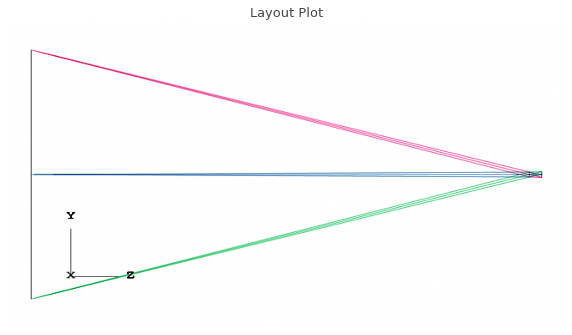

In [7]:
pyz.imshow(arr, cropBorderPixels=(5, 5, 20, 20), figsize=(10,10), title='Layout Plot')

In [8]:
# ... and the surfaces in LDE
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ TILTSURF              -            960                                500              -
   1 STANDARD       Infinity             40                                  0              0 dummy 2 c rays
   2 STANDARD       Infinity              0                                  0              0 Move to ENPP
   3 COORDBRK              -              0                                  -              - Lens tilt CB
   4 STANDARD       Infinity              0                                  0              0 dummy
   5 STANDARD       Infinity              0                                2.4              0 H
   6 STANDARD       Infinity            -24                                  0              0 dummy
   7 STANDARD       Infinity             24                                2.4              0 F
   8 STANDARD       Infinity              0                     

##### Determine appropriate parameters for image simulation

The parameters that we need to determine for proper* image simulation are the following:

1. Field height of the source image.
2. Oversampling factor (if any required).
3. Pupil sampling.
4. Image sampling.
5. Detector pixel size.
6. Detector x-pixels and y-pixels. 

\* *an image simulation that is adequately representative of real world imaging.*

###### Addition of Zernike Standard Phase Surface (and small amount of aberration)

We insert a Zernike Standard Phase surface co-located with the exit pupil (i.e. in the LDE, its position is just before the exit pupil surface, and its thickness set to zero). 

The Zernike Standard Phase surface serves two main purpose:

* We can systematically introduce aberrations to the baseline diffraction limited system to make the simulation more realistic.

* In Zemax image simulation, we set an appropriate pixel size to mimic a digital sensor. If the optical PSFs are too small (i.e. diffraction limited), we need to either set the object field height to a very small value and/or use oversampling in order to adequately sample the PSF. On the one hand, oversampling is a disadvantage because the simulation time increases exponentially, on the other using a miniscule object field height will not be a good representation of real world object. Yet, if we can avoid both these issues if we appropriately increase the size of the PSF by adding some amount of aberrations.    

In [9]:
# Get the surface number of the Exit Pupil
# It assumes that the exit-pupil surface has the commnet 'EXPP' 

for i in range(ln.zGetNumSurf()):
    if ln.zGetComment(i) == 'EXPP':
        break
print('Exit pupil surface number is:', i)

# Insert Zernike surface just before the exit pupil
zernSurfNum = i  # the new position of the EXPP surface will be i+1
ln.zInsertSurface(surfNum=zernSurfNum)
ln.zSetSurfaceData(surfNum=zernSurfNum, code=ln.SDAT_TYPE, value='SZERNPHA')

Exit pupil surface number is: 13


'SZERNPHA'

In [10]:
#ln.push

In [11]:
# Set Zernike surface's initial properties
maxTermCol = 1
maxTerm = 11  # upto primary spherical aberration
normRadiusCol = 2
normRadius = ln.zGetPupil().EXPD/2
priSphCol = 2 + 11   # 2 cols for maxTerm and normRadius plus 11th zernike term

ln.zSetExtra(zernSurfNum, maxTermCol, maxTerm)
ln.zSetExtra(zernSurfNum, normRadiusCol, normRadius)
# we will set the aberration terms later (depending on object field height and number of pixels)

5.0

Extract source image data and estimate simulation parameters

In [12]:
# If source bitmap image is not in the IMAFiles folder then 
# they are copied from local directory to IMA files directory
usr = os.path.expandvars("%userprofile%")
IMAdir = os.path.join(usr, 'Documents\Zemax\IMAFiles')
images = ['king.jpg', 'queen.jpg', 'jack.jpg']
imgSrcDir = os.path.join(curDir, 'images')
for image in images:
    imgfilename = os.path.join(IMAdir, image)
    if not os.path.exists(imgfilename):
        print('Copying {} to {}'.format(image, IMAdir))
        imgSrc = os.path.join(imgSrcDir, image)
        shutil.copy(imgSrc, imgfilename)
ypix, xpix, _ = imread(imgfilename).shape
        
print('Rows (y-pixels) =', ypix)
print('Cols (x-pixels) =', xpix)

Rows (y-pixels) = 1010
Cols (x-pixels) = 656


We emperically determined by tinkering in Zemax (we could also write functions to automatically determine the proper parameters) that in order to use object field height of 89.0 *mm* (physical height of standard playing cards) in the image simulation and still attain adequate sampling of the PSF, we require the pixel size (a side of square pixel) to be 0.0021668560298652812 *mm* and the Zernike standard coefficient number 11 for imparting small spherical aberration to be 0.126.

In [13]:
h = 89.0     # height of the object
ln.zSetExtra(zernSurfNum, priSphCol, 0.126)
detPixelSize, detXPixels, detYPixels = 0.0021668560298652812, 2853, 1330

In [14]:
 #ln.push

Now we will call the main image simulation function `focal_stack_fronto_parallel()`. 

In [15]:
# In the setup of the lens, it is expected that the first surface in the LDE (OBJ or 
# surfNum=0) is the object surface, following which is a dummy surface for rendering 
# incoming rays close to the lens (in physical space). Therefore, the PHYSICAL distance
# between the object surface and the vertex of the lens' left most surface is equal to
# the thickness of the OBJ surface plus the dummy surface in the LDE.

# In this particular experiment the thickness of the dummy surface was 40 mm
# 

# Settings for every composed image frame with object at 3 different depths 
# from the lens
dummySurfThick = 40    # in mm
objsurfthick = [1000-dummySurfThick, 800-dummySurfThick, 1200-dummySurfThick] 
objarr = ['king.jpg', 'queen.jpg', 'jack.jpg']
fldarr = [1, 4, 5]   # list of field numbers that are used for the corresponding 
                     # objects in `objarr` for image simulation in Zemax.
                     # Bcoz we have 3 objects that are spread along x-axis 
                     # (so that their images on the sensor are NOT coincident)
                     # we need to specify 3 fields along x-axis in the "Fields"
                     # in Zemax whose angular separation determines the 
                     # separation between the images of the 3 cards on the sensor

# settings for generation of the focal-sweep stack of images
focalLength = 24       # in mm
numOfImagesInStack = 3 #10

# function to generate the range of shifts of the image plane along the optical 
# axis relative to the base position (position at which the middle object is
# in geometrical focus)
imgDelta = gm.get_image_plane_shifts(nearObj=800, farObj=1200, fl=focalLength, 
                                     num=numOfImagesInStack) #[-1]
if not isinstance(imgDelta, list):
    imgDelta = list((imgDelta,))


# function to generate the image stack and store in an HDF5 container

# arguments to the function zSetImageSimulationsSettings()
X2, X4, X8, X16, X32 = 1, 2, 3, 4, 5  # oversampling
RGB = 0                               # Wavelength
NOAB, GEOM, DIFF = 0, 1, 2            # Aberration
S32by32, S64by64 = 1, 2               # Pupil/Image Sampling
CHIEF, VERTEX = 0, 1                  # reference
SIMIMG, SRCBMP, PSFGRID = 0, 1, 2     # show as 

hdffileFull = gm.focal_stack_fronto_parallel(ln, imgDelta=imgDelta, 
                                             objsurfthick=objsurfthick, 
                                             objarr=objarr, fldarr=fldarr, 
                                             objht=h, over=0, 
                                             pupsam=S32by32, imgsam=S32by32, 
                                             psfx=1, psfy=1, 
                                             pixsize=detPixelSize, 
                                             xpix=detXPixels, ypix=detYPixels, 
                                             timeout=240, verbose=True)


os.path.split(hdffileFull)[-1]

Time: 0:00:00. Starting image simulation for delta = -0.1004
Time: 0:03:30. Image sim of data type img for obj king.jpg for obj thick 960.00 completed!
Time: 0:07:08. Image sim of data type img for obj queen.jpg for obj thick 760.00 completed!
Time: 0:10:31. Image sim of data type img for obj jack.jpg for obj thick 1160.00 completed!
Time: 0:14:23. Image sim of data type img for obj imgsim_god.png for obj thick 960.00 completed!
Time: 0:18:20. Image sim of data type img for obj imgsim_god.png for obj thick 760.00 completed!
Time: 0:21:58. Image sim of data type img for obj imgsim_god.png for obj thick 1160.00 completed!
Traced for chief-ray intersects...
Time: 0:21:58. Starting image simulation for delta = 0.0000
Time: 0:25:21. Image sim of data type img for obj king.jpg for obj thick 960.00 completed!
Time: 0:28:55. Image sim of data type img for obj queen.jpg for obj thick 760.00 completed!
Time: 0:32:19. Image sim of data type img for obj jack.jpg for obj thick 1160.00 completed!
Ti

'fronto_para_focal_stack_2016_07_31_02_10.hdf5'

###### Inspect the data in the HDF5 file

In [16]:
from ipywidgets import widgets

def get_hdf5files_list():
    imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
    return [f for f in os.listdir(imgdir) if f.endswith('.hdf5')]

def show_image_stack(hdffile, i):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    with hdf.File(hdffile, 'r') as f:
        dgrp = f['data/'+'{}'.format(i).zfill(3)]
        dsetImg = f['data/'+'{}'.format(i).zfill(3)+'/image']
        ax.imshow(dsetImg[...], interpolation='none')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        print('Magnifications:', dgrp.attrs['mag'])
        plt.show()
    
def show_psf_stack(hdffile, i):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    with hdf.File(hdffile, 'r') as f:
        dgrp = f['data/'+'{}'.format(i).zfill(3)]
        dsetPsf = f['data/'+'{}'.format(i).zfill(3)+'/psf']
        ax.imshow(dsetPsf[...], interpolation='none')
        print('Magnifications:', dgrp.attrs['mag'])
        plt.show()
    
def show_cr_img_inter_stack(hdffile, i):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    with hdf.File(hdffile, 'r') as f:
        dgrp = f['data/'+'{}'.format(i).zfill(3)]
        x = f['data/'+'{}'.format(i).zfill(3)+'/cr_img_ipts/x']
        y = f['data/'+'{}'.format(i).zfill(3)+'/cr_img_ipts/y']
        ax.scatter(x[...], y[...], s=10, facecolors='none', 
                       edgecolors='r', alpha=0.8, zorder=12)
        print('Magnifications:', dgrp.attrs['mag'])
        plt.show()
    
def show_stack(hdffile, what):
    global iSelect
    if iSelect:
        iSelect.close()
    imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
    hdffile = os.path.join(imgdir, hdffile)
    with hdf.File(hdffile, 'r') as f:
        stackLen = len(f['data'])
        iSelect = widgets.IntSlider(value=0, 
                                    min=0, 
                                    max=stackLen-1, 
                                    step=1, description='ImageNum', 
                                    orientation='horizontal')
        interact(what, hdffile=fixed(hdffile), i=iSelect)

Magnifications: [-0.02474227 -0.03092784 -0.02061856]


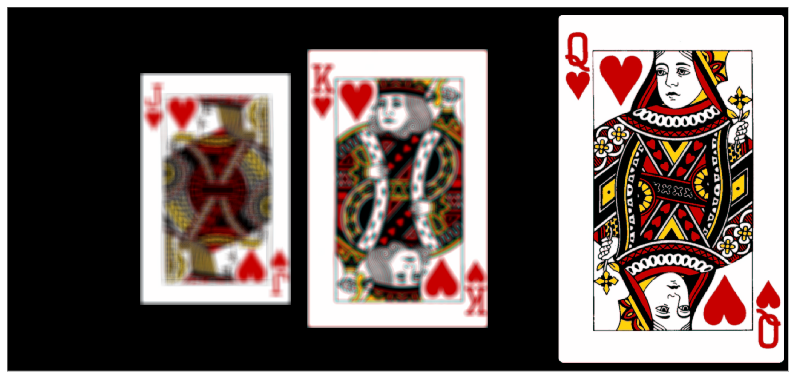

In [17]:
iSelect = None
interact(show_stack, hdffile=get_hdf5files_list(),  what={'Images':show_image_stack,
               'PSF Grids':show_psf_stack, 'CR IMG int.':show_cr_img_inter_stack});

In [20]:
gc.collect()

0

In [21]:
#ln.close()

### Paraxial double lens - angular sweep stack

In [8]:
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialDoubleLens24mmFiniteConj_mp1_cardinalsDrawnWdRotAbtENPP.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()

In [9]:
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ TILTSURF              -            990                                500              -
   1 STANDARD       Infinity             10                                  0              0 dummy 2 c rays
   2 STANDARD       Infinity             16                                  0              0 Move to ENPP
   3 COORDBRK              -            -16                                  -              - Lens tilt CB
   4 STANDARD       Infinity             16                                  0              0 dummy
   5 STANDARD       Infinity            -16                                2.4              0 H
   6 STANDARD       Infinity             -8                                  0              0 dummy
   7 STANDARD       Infinity              8                                2.4              0 F
   8 STANDARD       Infinity             16                     

In [10]:
#ln.push

In [11]:
# To change focus from the middle surface to some other surface in plane parallel configuration

#deltai = 0.1466628      # focus on the front surface
#deltai = 0.0901633      # focus 1/3rd the distance between the first and mid surface from the first towards mid
#deltai = 0.095
#deltai = 0.2517254      # focus 100 mm infront of the first object (this will increase the maximum amount
                        # of lens rotation required) 
deltai = 0.1956346      # focus 50 mm infront of the first object ... the DOF for the previous one was a little too shallow
    
surfNum = ln.zGetNumSurf()
ln.zInsertSurface(surfNum)
ln.zSetThickness(surfNum, deltai)

0.1956346

In [12]:
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ TILTSURF              -            990                                500              -
   1 STANDARD       Infinity             10                                  0              0 dummy 2 c rays
   2 STANDARD       Infinity             16                                  0              0 Move to ENPP
   3 COORDBRK              -            -16                                  -              - Lens tilt CB
   4 STANDARD       Infinity             16                                  0              0 dummy
   5 STANDARD       Infinity            -16                                2.4              0 H
   6 STANDARD       Infinity             -8                                  0              0 dummy
   7 STANDARD       Infinity              8                                2.4              0 F
   8 STANDARD       Infinity             16                     

In [13]:
#ln.push

In [14]:
for i in range(ln.zGetNumSurf()):
    if ln.zGetComment(i) == 'EXPP':
        break
print('Exit pupil surface number is:', i)

Exit pupil surface number is: 14


In [15]:
# Insert Zernike surface at the EX
zernSurfNum = i  # the new position of the EXPP surface will be i+1
ln.zInsertSurface(surfNum=zernSurfNum)
ln.zSetSurfaceData(surfNum=zernSurfNum, code=ln.SDAT_TYPE, value='SZERNPHA')

'SZERNPHA'

In [16]:
#ln.push

In [17]:
# Set Zernike surface's initial properties
maxTermCol = 1
maxTerm = 11  # upto primary spherical aberration
normRadiusCol = 2
normRadius = ln.zGetPupil().EXPD/2
priSphCol = 2 + 11   # 2 cols for maxTerm and normRadius plus 11th zernike term

ln.zSetExtra(zernSurfNum, maxTermCol, maxTerm)
ln.zSetExtra(zernSurfNum, normRadiusCol, normRadius)
# we will set the aberration terms later

5.0

In [18]:
# source bitmap image is assumed to be in the IMAFiles folder
usr = os.path.expandvars("%userprofile%")
IMAdir = os.path.join(usr, 'Documents\Zemax\IMAFiles')
image = 'king.jpg'
imgfilename = os.path.join(IMAdir, image)
imgfilename

'C:\\Users\\Indranil\\Documents\\Zemax\\IMAFiles\\king.jpg'

In [19]:
ypix, xpix, _ = imread(imgfilename).shape
ypix, xpix

(1010L, 656L)

In [20]:
h = 89.0
ho = gm.get_cardinal_points(ln).Ho

detDat = gm.get_detector_settings(h=h, xpix=xpix, ypix=ypix, fl=24, xfield=70, 
                                  umid=ho+990, 
                                  unear=ho+790, 
                                  ufar=ho+1190)
detPixelSize, detXPixels, detYPixels = detDat
detPixelSize, detXPixels, detYPixels

(0.0017812641832943904, 3375, 1565)

In [21]:
cb1 = 3

In [22]:
h = 89.0
ln.zSetExtra(zernSurfNum, priSphCol, 0.126)
#detPixelSize, detXPixels, detYPixels = 0.0021668560298652812, 2853, 1330

#detPixelSize, detXPixels, detYPixels = 0.00178, 3375, 2320  # for ±5° tilt about x
#detPixelSize, detXPixels, detYPixels = 0.00178, 3375, 2500  # for ±6° tilt about x
detPixelSize, detXPixels, detYPixels = 0.00178, 3380, 2800   # for ±8° tilt about x

###### TO DO

1. Function to determine the appropriate tilts


In [ ]:
#ln.push

In [23]:
# In the setup of the lens, it is expected that the first surface in the LDE (OBJ or 
# surfNum=0) is the object surface, following which is the dummy surface for rendering 
# incoming rays close to the lens (in physical space). Therefore the PHYSICAL distance
# between the object surface and the vertex of the lens' left most surface is equal to
# the thickness of the OBJ surface and the dummy surface in the LDE.

# Settings for every composed image frame with object at 3 different depths 
# from the lens
dummySurfThick = ln.zGetThickness(surfNum=1)

# fetch the dummySurfThick from the 

objsurfthick = [1000-dummySurfThick, 800-dummySurfThick, 1200-dummySurfThick] 
objarr = ['king.jpg', 'queen.jpg', 'jack.jpg']
fldarr = [1, 4, 5]

# settings for generation of the focal-sweep stack of images
focalLength = 24
numOfImagesInStack = 13 #15

# function to generate the range of angular shifts of the image plane along the optical 
# axis relative to the base position (position at which the middle object is
# in geometrical focus)
angDelta = gm.get_lens_plane_tilts(uo=1000, nearObj=800, farObj=1200, fl=focalLength, 
                                     num=numOfImagesInStack) #[-1]
if not isinstance(angDelta, list):
    angDelta = list((angDelta,))

# function to generate the image stack and store in an HDF5 container

# arguments to the function zSetImageSimulationsSettings()

X2, X4, X8, X16, X32 = 1, 2, 3, 4, 5  # oversampling
RGB = 0                               # Wavelength
S32by32, S64by64 = 1, 2               # Pupil/Image Sampling
AB_NONE, AB_GEO, AB_DIFF = 0, 1, 2    # Aberration

hdffileFull = gm.focal_stack_lens_tilts(ln, cb1=cb1, tiltX=angDelta, 
                                        objsurfthick=objsurfthick, 
                                        objarr=objarr, fldarr=fldarr, 
                                        objht=h, over=0, 
                                        pupsam=S64by64, imgsam=S64by64, 
                                        psfx=5, psfy=5, 
                                        pixsize=detPixelSize, 
                                        xpix=detXPixels, ypix=detYPixels,
                                        aberr=AB_DIFF, psfGrid=False,
                                        timeout=60*20, verbose=True)

os.path.split(hdffileFull)[-1]

TO IMPLEMENT
Time: 0:00:00. Starting image simulation for tiltAbtX = -8.0000
Time: 0:10:11. Image sim of data type img for obj king.jpg for obj thick 990.00 completed!
Time: 0:21:03. Image sim of data type img for obj queen.jpg for obj thick 790.00 completed!
Time: 0:30:55. Image sim of data type img for obj jack.jpg for obj thick 1190.00 completed!
Traced chief-ray intersects.
Time: 0:31:08. Starting image simulation for tiltAbtX = -6.6667
Time: 0:41:27. Image sim of data type img for obj king.jpg for obj thick 990.00 completed!
Time: 0:52:31. Image sim of data type img for obj queen.jpg for obj thick 790.00 completed!
Time: 1:02:17. Image sim of data type img for obj jack.jpg for obj thick 1190.00 completed!
Traced chief-ray intersects.
Time: 1:02:20. Starting image simulation for tiltAbtX = -5.3333
Time: 1:12:01. Image sim of data type img for obj king.jpg for obj thick 990.00 completed!
Time: 1:22:00. Image sim of data type img for obj queen.jpg for obj thick 790.00 completed!
Time

'lens_tilt_focal_stack_2016_03_21_02_19.hdf5'

#### View data and process

Mags: -0.029, -0.035, -0.025


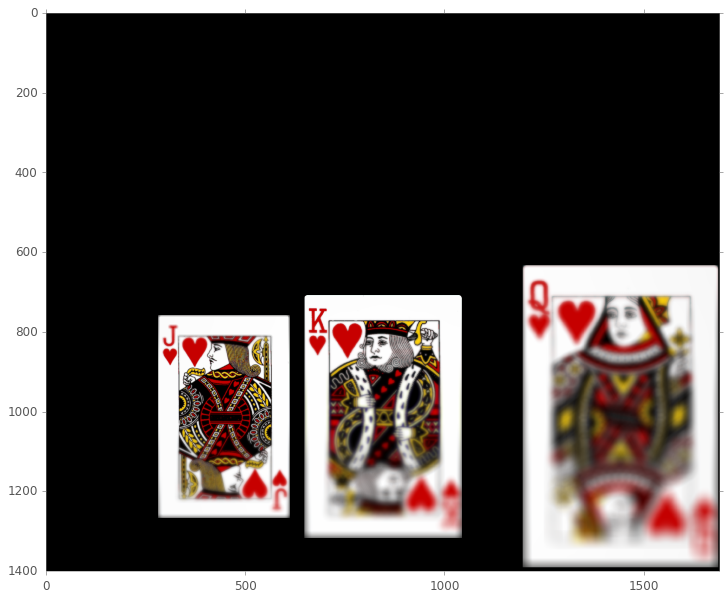

In [24]:
plt.close('all') # to close all open figures ... especially important if the notebook environment is on
gm.iSelect = None  # Hack for now

interact(gm.show_stack, hdffile=gm.get_hdf5files_list(),  
         what={'Images': gm.show_image_stack,
               'PSF Grid': gm.show_psf_stack, 
               'CR IMG int.': gm.show_cr_img_inter_stack,});

Observations (general, without proof ... but see if it can be proved mathematically)

1. It seems that we should probably be start (for the zero tilt instance) with focus before the first object plane of interest
2. Point 1 means that the zero tilt image will not have any thing (of interest) in focus .... then we should probably not capture any image at zero tilt .... TODO: I need to fix the code to work without the zero tilt image ... but still register everything to that position.
3. Focusing closer to the camera (in front of the first object) has two main consequences and a few sub consequences:
  * We usually need to increase the extent of the tilt angles. This usually means that we need to capture more image.
  * The DOF perpendicular to the plane of sharp focus (tilted) becomes shallow ... therefore, we need to capture more images (at finer angular resolution).

In [25]:
# if %matplotlib notebook backend is on 
gc.collect()
plt.close('all')

###### Perform image registration

<font color='red'>TODO @ registration</font>: I need to fix the code to work without the zero tilt image ... but still register everything to that position.
Actually most of the images near zero lens tilts doesn't provide any in-focus regions.

In [27]:
# register the most recent data
hdffile = gm.get_hdf5files_list()[-1]
print("HDF file :", hdffile)
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
hdffile = os.path.join(imgdir, hdffile)

gm.register_data(hdffile)

HDF file : lens_tilt_focal_stack_2016_03_21_02_19.hdf5
OK


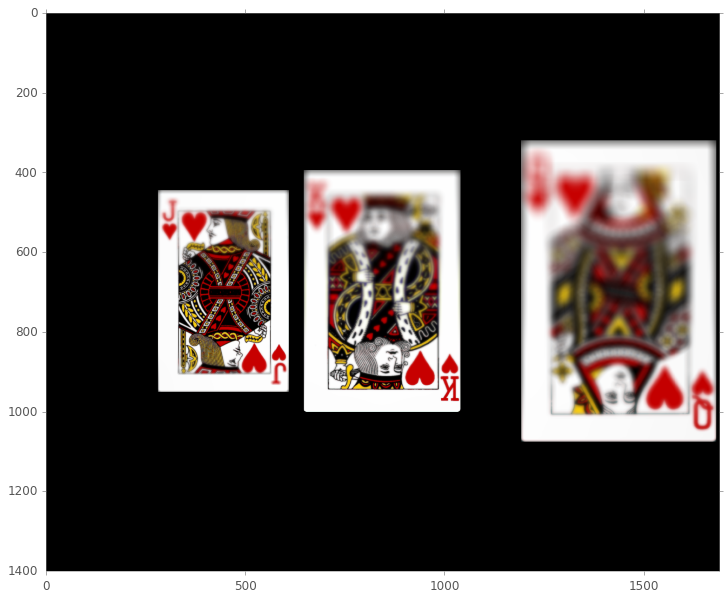

In [28]:
plt.close('all') # to close all open figures ... especially important if the notebook environment is on
gm.iSelect = None  # Hack for now

interact(gm.show_stack, hdffile=gm.get_hdf5files_list(),  
         what={'Rect. Images': gm.show_registered_image_stack,
               'Rect. PSF Grid': gm.show_registered_psf_stack});

In [29]:
#if ln:
#    ln.close()

In [30]:
gc.collect()

34315

In [36]:
# Save unregistered images as unregistered_png_stack
hdffile = gm.get_hdf5files_list()[-1]
print('HDF File:', hdffile)
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
hdffile = os.path.join(imgdir, hdffile)
imgsavedir = os.path.join(imgdir, 'unregistered_png_stack')
# clean up the directory
for each in os.listdir(imgsavedir):
    os.remove(os.path.join(imgsavedir,each))
# save new images
gm.save_unregistered_images(hdffile, imgsavedir)

HDF File: lens_tilt_focal_stack_2016_03_21_02_19.hdf5
No. of images: 13
OK


In [37]:
# Save registered images as png_stack
hdffile = gm.get_hdf5files_list()[-1]
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
hdffile = os.path.join(imgdir, hdffile)
imgsavedir = os.path.join(imgdir, 'png_stack')
# clean up the directory
for each in os.listdir(imgsavedir):
    os.remove(os.path.join(imgsavedir,each))
# save new images
gm.save_registered_images(hdffile, imgsavedir)

No. of images: 13
OK


In [38]:
# create thumbnails
import os
import iutils.image.general as ig
from scipy.misc import imread, imsave

imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
imgsavedir = os.path.join(imgdir, 'unregistered_png_stack')
thumbnaildir = os.path.join(imgdir, 'thumbnail_stack')

# clean up the thumbnail directory
for each in os.listdir(thumbnaildir):
    os.remove(os.path.join(thumbnaildir,each))

#img.imresize()
 
for each in ig.get_imlist(imgsavedir, 'png'):
    img = imread(each)
    #rimg = ig.imresize(img, (3375//3, 2500//3))
    rimg = ig.imresize(img, (3380//3, 2800//3))
    imgname = os.path.split(each)[-1]
    imgfile = os.path.join(thumbnaildir, imgname)
    imsave(imgfile, rimg)
print('OK')

OK


#### Test homography

In [42]:
# register the most recent data
hdffile = gm.get_hdf5files_list()[-1]
print('HDF file :', hdffile)
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
hdffile = os.path.join(imgdir, hdffile)
print('HDF file fullpath:', hdffile)

HDF file : lens_tilt_focal_stack_2016_03_21_02_19.hdf5
HDF file fullpath: C:\GIT_REPOSITORIES\phd-artifacts\chapters\chapter03_geometricmodel\code\data\imgstack\lens_tilt_focal_stack_2016_03_21_02_19.hdf5


In [43]:
tiltCnt = 0 # tiltCnt number 0 is for the extreme angle; -8° (for the particular example) 
# 
with hdf.File(hdffile, 'r') as f:
    beta = f['data/'+'{}'.format(tiltCnt).zfill(3)].attrs['tilt_x']
    Hcr = gm._get_homography_from_CR_intersects(f, tiltCnt)

print('Tilt-x =', beta)
for i in range(3):
    print('\nH({}) ='.format(i+1))
    print(np.round(Hcr[:, :, i], 5))

Tilt-x = -8.0

H(1) =
[[   0.99686    0.         0.     ]
 [   0.         0.99686 -625.49708]
 [   0.         0.         1.     ]]

H(2) =
[[   0.99686    0.         0.     ]
 [   0.         0.99686 -625.49703]
 [   0.         0.         1.     ]]

H(3) =
[[   0.99686    0.         0.     ]
 [   0.         0.99686 -625.49708]
 [   0.         0.         1.     ]]


###### Analytically determined shift and magnification

In [44]:
ln.zSetSurfaceParameter(surfNum=cb1, param=3, value=0)
ln.zGetUpdate()

0

In [45]:
# method 1: If the ENP, EXP surface numbers are known
def get_vertex_distances_method1(ln, enpSurfNum, expSurfNum):
    """
    d : Exit pupil - Entrance pupil distance
    zdasho : Enpp to Image plane distance
    """
    enppGlobal = ln.zOperandValue('GLCZ', enpSurfNum)
    exppGlobal = ln.zOperandValue('GLCZ', expSurfNum)
    imgSurfNum = ln.zGetNumSurf()
    imgGlobal = ln.zOperandValue('GLCZ', imgSurfNum)
    d = exppGlobal - enppGlobal
    zdasho = imgGlobal - enppGlobal
    return d, zdasho
    
get_vertex_distances_method1(ln, 9, 14)

(-8.0, 16.776280000000042)

In [46]:
# method 2: Using Prescription 
def get_vertex_distances_method2(ln):
    firstSurfGlobal = ln.zOperandValue('GLCZ', 1)
    imgSurfNum = ln.zGetNumSurf()
    imgGlobal = ln.zOperandValue('GLCZ', imgSurfNum)
    pupilData = ln.zGetPupil()
    firstSurfToENPP = pupilData.ENPP
    imgSurfToEXPP = pupilData.EXPP
    firstSurfToImg = imgGlobal - firstSurfGlobal
    firstSurfToEXPP = firstSurfToImg + imgSurfToEXPP
    d = firstSurfToEXPP - firstSurfToENPP
    zdasho = firstSurfToImg - firstSurfToENPP
    return d, zdasho
    
get_vertex_distances_method2(ln)

(-7.999999759999959, 16.776280000000042)

In [47]:
d, zdasho = get_vertex_distances_method2(ln)

print('Entrance-to-exit pupil distance, d = ', d)
print('zdasho = ', zdasho)

Entrance-to-exit pupil distance, d =  -7.99999976
zdasho =  16.77628


In [48]:
mag = (d*np.cos(np.deg2rad(-8.0)) - zdasho)/(d - zdasho)
print('mag = ', mag)

mag =  0.996857661905


In [50]:
dpixsize = 0.00178
shift_metric =  d*np.sin(np.deg2rad(-8.0))
shift_pixels = shift_metric/dpixsize
print('shift @ metric = ', shift_metric, ' mm')
print('shift @ pixels = ', shift_pixels)

shift @ metric =  1.11338477428  mm
shift @ pixels =  625.497064202


In [51]:
if ln:
    ln.close()

## Blending the images in the stack

In [7]:
from __future__ import print_function, division
import os
import gc
import cv2
import numpy as np
import iutils.image.general as ig
from scipy.misc import imread, imsave
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interactive

In [8]:
%matplotlib

Using matplotlib backend: nbAgg


In [10]:
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
#png_stack_dir = os.path.join(imgdir, 'png_stack')   # the images in this stack are already registered

png_stack_dir = os.path.join(imgdir, 'unregistered_png_stack')  

In [11]:
png_stack_dir

'C:\\GIT_REPOSITORIES\\phd-artifacts\\chapters\\chapter03_geometricmodel\\code\\data\\imgstack\\unregistered_png_stack'

In [31]:
img = imread(png_stack_dir + '\\000.png')

In [28]:
ig.imshow(img, figsize=(12, 8));

In [9]:
# application of LoG or Energy of Laplacian

def focal_measure(img, method='LoG', sigma=2, morpho=0, mkern_size=5):
    """returns the focal measure within a frame
    
       @method : 'LoG', 'LoGE', 'LAP', 'LAPE'
       @sigma : standard-deviation for Gaussian filter in LoG and LoGE
       @morpho : 0=no morphological operations, 1=dilation only, 2=closing
       @mkern_size : kernel size of morphological operation
    """
    
    assert method in ('LoG', 'LoGE', 'LAP', 'LAPE'), 'Invalid method'
    
    # weights for combining the color channels
    wt_r, wt_g, wt_b = 1.0/3, 1.0/3, 1.0/3

    if method == 'LoG' or method == 'LoGE':
        _filter = ndi.gaussian_laplace
    elif method == 'LAP' or method == 'LAPE':
        _filter = ndi.laplace
    
    # Ensure that the image data type is float 64
    img = img.astype('float64')    
    
    if method == 'LoG' or method == 'LoGE':
        fm = (wt_r*np.abs(_filter(img[:,:, 0], sigma=sigma, truncate=5)) + 
              wt_g*np.abs(_filter(img[:,:, 1], sigma=sigma, truncate=5)) +
              wt_b*np.abs(_filter(img[:,:, 2], sigma=sigma, truncate=5)))
        if method == 'LoGE':
            fm = fm**2

    elif method == 'LAP' or method == 'LAPE':
        fm = (wt_r*np.abs(_filter(img[:,:, 0])) + 
              wt_g*np.abs(_filter(img[:,:, 1])) +
              wt_b*np.abs(_filter(img[:,:, 2])))
        
        if method == 'LAPE':
            fm = fm/np.max(fm)
            fm = 255*fm**2

    # Morphological operation
    morpho_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                          (mkern_size, mkern_size))
    if morpho == 1:
        fm = cv2.morphologyEx(fm, cv2.MORPH_DILATE, morpho_kernel)
    elif morpho == 2:
        fm = cv2.morphologyEx(fm, cv2.MORPH_CLOSE, morpho_kernel)
    return fm

In [32]:
morpho = 1
sigma =  2
fm_LoG = focal_measure(img, method='LoG', sigma=sigma, morpho=morpho)
fm_LoGE = focal_measure(img, method='LoGE', sigma=sigma, morpho=morpho)
fm_LAP = focal_measure(img, method='LAP', morpho=morpho)
fm_LAPE = focal_measure(img, method='LAPE', morpho=morpho)

In [10]:
def show_focal_measure(focal_measure, colormap):
    fm_dict = {'LoG': fm_LoG, 'LoGE': fm_LoGE,'LAP': fm_LAP, 'LAPE': fm_LAPE}
    cmap_dict ={'magma': plt.cm.magma, 'virdis': plt.cm.viridis, 'plasma':plt.cm.plasma}
    img = fm_dict[focal_measure]
    if focal_measure == 'LoG':  # only for display purpose
        img = img**1.5
    ig.imshow(image=img, figsize=(13, 9),  
              cmap=cmap_dict[colormap]);

In [34]:
# display focal measures
v = interactive(show_focal_measure, 
                focal_measure=('LoG', 'LoGE', 'LAP', 'LAPE'), 
                colormap=('magma', 'virdis', 'plasma'))
display(v)

In [21]:
gc.collect()

3285

In [17]:
# create stack and  (assumes that the images are already aligned)
# currently the the registered images are being collected from the png_stack folder
# TODO: the input data could also be from the registered arrays in the HDF file

gc.collect()
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
png_stack_dir = os.path.join(imgdir, 'png_stack')
imglist = ig.get_imlist(filePath=png_stack_dir, itype='png')

#morpho = 1
#sigma = 2
#method = 'LAP'
#method = 'LoG'
method = 'LoGE'

# create focal_measure stack
img_rgb_stack = [imread(image) for image in imglist]  # to do ... memory map to HDF file
fm_measure_stack = [focal_measure(img, method, sigma, morpho) for img in img_rgb_stack]
fm_measure_stack = np.dstack(fm_measure_stack)

In [18]:
# create composite
composite_img = np.zeros_like(img_rgb_stack[0])
fm_max_indices = np.argmax(fm_measure_stack, axis=2)
for index in range(len(imglist)):
    mask = fm_max_indices==index
    composite_img[:, :, 0] = composite_img[:, :, 0] + img_rgb_stack[index][:,:,0]*mask   
    composite_img[:, :, 1] = composite_img[:, :, 1] + img_rgb_stack[index][:,:,1]*mask   
    composite_img[:, :, 2] = composite_img[:, :, 2] + img_rgb_stack[index][:,:,2]*mask  

<IPython.core.display.Javascript object>


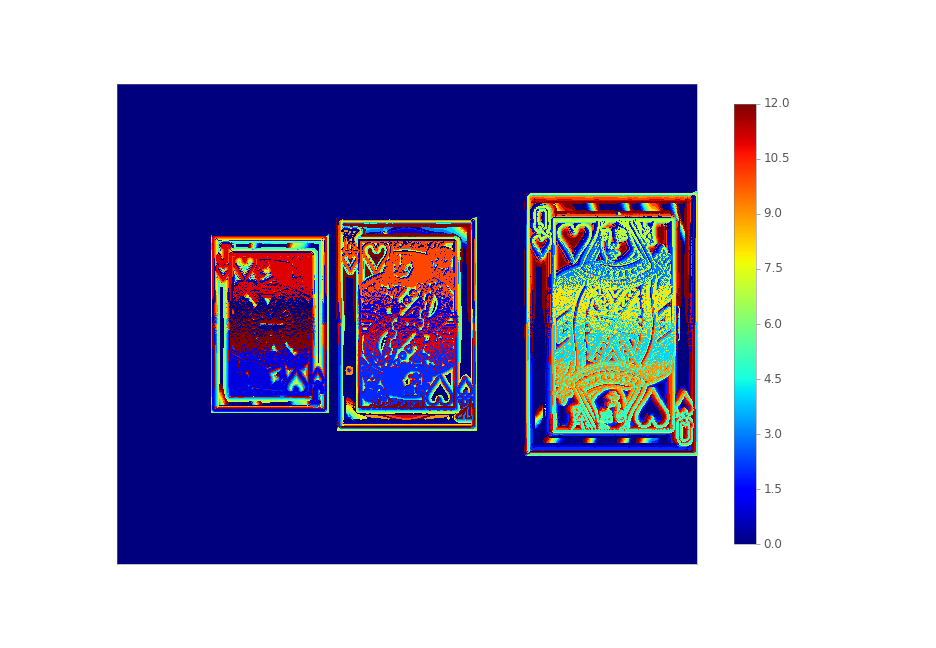

In [19]:
# show max_indices map
cmap = plt.get_cmap(name=plt.cm.jet, lut=len(imglist))
#img, fig, ax = ig.imshow(image=(fm_max_indices==0), figsize=(13, 9), cmap=cmap, interpol='none')
img, fig, ax = ig.imshow(image=fm_max_indices, figsize=(13, 9), cmap=cmap, interpol='none')
plt.colorbar(shrink=0.85);

<IPython.core.display.Javascript object>


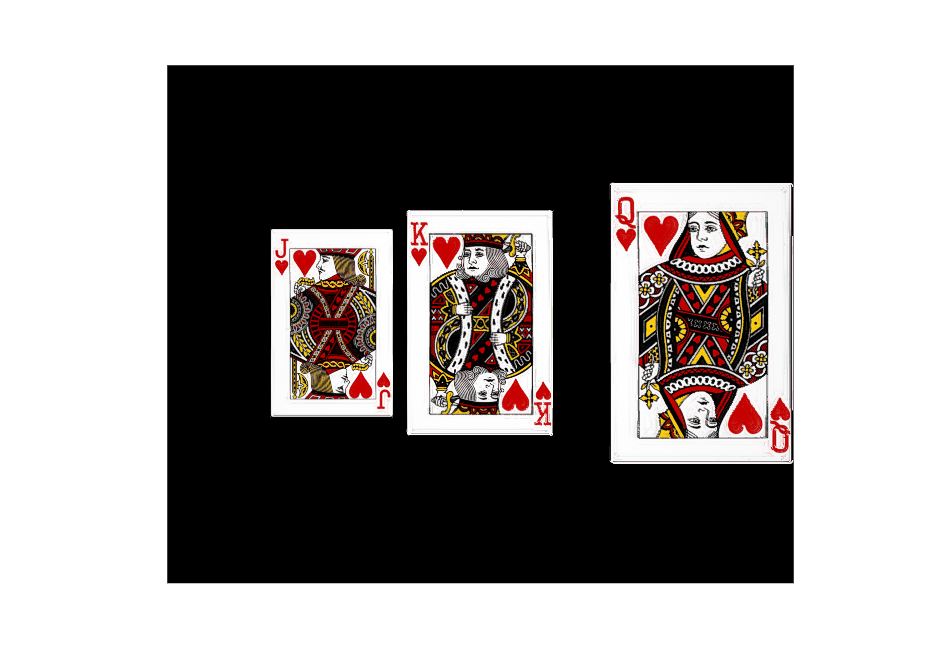

In [20]:
ig.imshow(image=composite_img, figsize=(13, 9));

In [21]:
gc.collect()

3500

In [24]:
# focal measure of the composed image
fm_composite_LoG = focal_measure(composite_img, method='LoG', sigma=sigma, morpho=morpho)

<IPython.core.display.Javascript object>


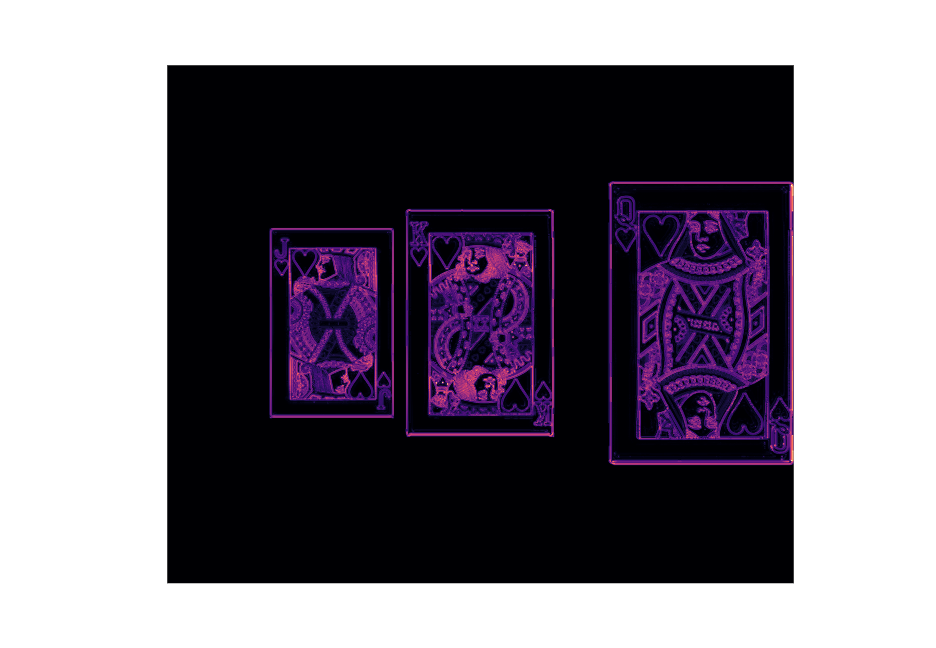

In [25]:
ig.imshow(image=fm_composite_LoG, figsize=(13, 9), cmap='magma');

In [26]:
gc.collect()

6518

In [4]:
from IPython.core.display import HTML
import urllib2
def css_styling():
    url = 'https://raw.githubusercontent.com/indranilsinharoy/python_env_stylefiles/master/custom.css'
    styles = urllib2.urlopen(url).read()
    return HTML(styles)
css_styling();